In [1]:
import mkl
mkl.set_num_threads(1)

48

# Import & settings

In [2]:
import sys
sys.path.insert(0, "../../core/")

from os.path import join
from collections import namedtuple
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from pickle import load
from scipy.stats import chi2

# PLEnuM tools
import settings as st
from tools import get_mids
from fluxes import ngc_flux, ngc_cut_flux, PL_flux, PLcut_flux, power_law, cut_off
from aeff_calculations import get_aeff_and_binnings

# plot settings
import seaborn as sns
from matplotlib.patches import Rectangle
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# plt.style.use("../../style.mplstyle")

plot_path = "plots/odysseus"
#plot_path = "plots/paper"

Could not import healpy.
functions plot_area, add_catalog, and add_extended_plane will not work.


# scaled DP

In [3]:
from scipy.interpolate import splev, splrep

In [6]:
with open(join(st.BASEPATH, "local/detection_efficiencies.pckl"), "rb") as f:
    det_eff, padded_sd = load(f)

In [8]:
## NGC1068 paper
# ngc: 
phi_ngc_32 = 6.75693e-11 # gamma=-3.2
phi_ngc_20 = 9.63442e-13 # gamma=-2.0
# txs:
phi_txs_32 =  4.39509e-11 # gamma=-3.2
phi_txs_20 = 7.51983e-13 # gamma=-2.0

# load the data
ps_disc = dict()
ind_disc = dict()
xsd = dict()
ic_10yr = dict()
spl_10yr = dict()


gamma = 2.0
ps_disc[gamma] = np.genfromtxt(
    join(st.LOCALPATH, "ngc_DP_gamma-2.txt"), delimiter=","
)
gamma = 3.2
ps_disc[gamma] = np.genfromtxt(
    join(st.LOCALPATH, "ngc_DP_gamma-3,2.txt"), delimiter=","
)
gammas = ps_disc.keys()

for gamma in ps_disc:
    ind_disc[gamma] = np.argsort(ps_disc[gamma][:, 0])
    xsd[gamma] = ps_disc[gamma][:, 0][ind_disc[gamma]]
    ic_10yr[gamma] = ps_disc[gamma][:, 1][ind_disc[gamma]] * 1E-12
    spl_10yr[gamma] = splrep(xsd[gamma], ic_10yr[gamma])

reference_ddecs = np.array([st.ngc1068.dec.deg, 30])
reference_sdecs = np.sin(np.deg2rad(reference_ddecs))

In [9]:
gen2 = dict()
ic_20yr = dict()
ic_ntn = dict()
pone = dict()
plenum1 = dict()
plenum2 = dict()
ic_plenum1 = dict()
ic_plenum2 = dict()
for gamma in gammas:
    ic_20yr[gamma] = ic_10yr[gamma] * (
        0.5**0.8
    )  # double time from 10yr baseline to 20yr
    # plenum-1 10yr
    ic_ntn[gamma] = (
        ic_10yr[gamma]
        * (
            np.exp(det_eff[gamma]["IceCube"](xsd[gamma]))
            / (
                np.exp(det_eff[gamma]["IceCube"](xsd[gamma]))
                + np.exp(det_eff[gamma]["P-ONE"](xsd[gamma]))
            )
        )
        ** 0.8
    )
    # pone 10yr
    pone[gamma] = ic_10yr[gamma] * np.exp(
        (det_eff[gamma]["IceCube"](xsd[gamma]) - det_eff[gamma]["P-ONE"](xsd[gamma]))
        * 0.8
    )
    # gen2 10yr
    gen2[gamma] = ic_10yr[gamma] * np.exp(
        (det_eff[gamma]["IceCube"](xsd[gamma]) - det_eff[gamma]["Gen-2"](xsd[gamma]))
        * 0.8
    )
    # plenum-1 10yr
    plenum1[gamma] = ic_10yr[gamma] * np.exp(
        (det_eff[gamma]["IceCube"](xsd[gamma]) - det_eff[gamma]["Plenum-1"](xsd[gamma]))
        * 0.8
    )
    # plenum-2 10yr
    plenum2[gamma] = ic_10yr[gamma] * np.exp(
        (det_eff[gamma]["IceCube"](xsd[gamma]) - det_eff[gamma]["Plenum-2"](xsd[gamma]))
        * 0.8
    )
    # 10 yr icecube, then 10yr plenum-1 (with icecube)
    ic_plenum1[gamma] = (
        ic_10yr[gamma] ** (-1 / 0.8) + plenum1[gamma] ** (-1 / 0.8)
    ) ** -0.8
    # 10 yr icecube, then 10yr plenum-2 (with gen2)
    ic_plenum2[gamma] = (
        ic_10yr[gamma] ** (-1 / 0.8) + plenum2[gamma] ** (-1 / 0.8)
    ) ** -0.8


In [10]:
fontsize=15

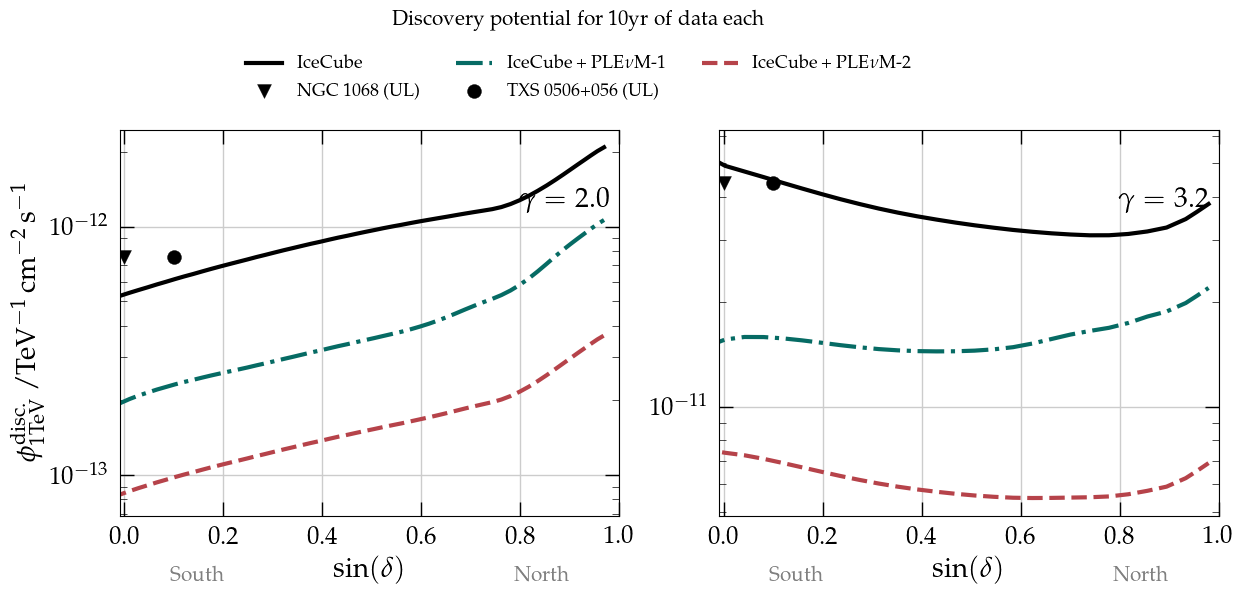

In [11]:
f, axes = plt.subplots(ncols=2, figsize=(14, 6))

for ii, gamma in enumerate(gammas):
    ax = axes[ii]
    # conversion to flux normalisation at 100TeV in 1/GeV /cm2/s
    const = 1  #  10**(-2*gamma) / 1.e3

    ax.plot(
        xsd[gamma],
        ic_10yr[gamma] * const,
        color="k",
        ls="-",
        lw=3,
        label=r"IceCube" if ii == 0 else "",
    )
    ax.scatter(
        np.sin(st.ngc1068.icrs.dec),
        phi_txs_20 if gamma == 2 else phi_txs_32,
        marker="v",
        color="k",
        label="NGC 1068 (UL)" if gamma == 2 else "",
        zorder=10,
        s=100,
    )
    ax.plot(
        xsd[gamma],
        ic_plenum1[gamma] * const,
        color=st.colors[2],
        ls="-.",
        lw=3,
        label=r"IceCube + PLE$\nu$M-1" if ii == 0 else "",
    )
    ax.scatter(
        np.sin(st.txs0506.icrs.dec),
        phi_txs_20 if gamma == 2 else phi_txs_32,
        marker="o",
        color="k",
        label="TXS 0506+056 (UL)" if gamma == 2 else "",
        zorder=10,
        s=100,
    )
    ax.plot(
        xsd[gamma],
        ic_plenum2[gamma] * const,
        color=st.colors[3],
        ls="--",
        lw=3,
        label=r"IceCube + PLE$\nu$M-2" if ii == 0 else "",
    )
    ax.axvline(np.sin(st.sgr_a.icrs.dec), ls="--", color="k", lw=1)
    ax.set_yscale("log")
    ax.set_xlim(-0.01, 1)
    ax.tick_params(axis="both", which="major")

    ylim = ax.get_ylim()
    ax.text(
        0.98,
        0.8,
        r"$\gamma={0:.1f}$".format(gamma),
        fontsize=fontsize + 5,
        transform=ax.transAxes,
        ha="right",
    )

    ax.set_xlabel(r"$\sin(\delta)$", fontsize=fontsize + 5)
    ax.text(
        0.1,
        -0.17,
        "South",
        fontsize=fontsize,
        fontdict=dict(color="gray"),
        transform=ax.transAxes,
    )
    ax.text(
        0.9,
        -0.17,
        "North",
        fontsize=fontsize,
        fontdict=dict(color="gray"),
        transform=ax.transAxes,
        ha="right",
    )
axes[0].set_ylabel(
    r"$\phi^{\mathrm{disc.}}_{1\rm TeV} ~ / \rm TeV^{-1} \, cm^{-2} \, s^{-1}$",
    fontsize=fontsize + 5,
)

f.legend(
    loc="upper center",
    ncol=3,
    frameon=False,
    fontsize=fontsize - 2,
    bbox_to_anchor=(0.5, 0.93),
)
f.subplots_adjust(top=0.78)
f.suptitle("Discovery potential for 10yr of data each", fontsize=fontsize)
f.savefig(
    join(st.BASEPATH, plot_path, f"plenum_ps_disc_pot_comparison_gamma23.pdf"),
    bbox_inches="tight",
)


# DP source


In [6]:
flux_ps = pd.read_pickle(join(st.BASEPATH, "resources/flux_ngc_disc_pot.pickle"))

In [7]:
# plot settings for different detector_configurations
det_plotting = {
    "IceCube": {
        "color": "k",
        "ls": "-",
        "label": "IceCube (IC) 10 yr (est.)",
        "plainlabel": "IceCube",
        "marker": "d",
    },
    "P-ONE": {
        "color": "#66cccc",
        "ls": "--",
        "label": "IC 10~yr + IC-North 10~yr",
        "plainlabel": "P-ONE",
        "marker": "v",
    },
    "KM3NeT": {
        "color": "#66cccc",
        "ls": "--",
        "label": "IC + KM3NeT",
        "plainlabel": "KM3NeT",
        "marker": "v",
    },
    "Plenum-1": {
        "color": "#339999",
        "ls": "-",
        "label": r"IC 10~yr + PLE$\nu$M-1 10~yr",
        "plainlabel": r"PLE$\nu$M-1",
        "marker": "s",
    },
    "Plenum-2": {
        "color": "#a50000",
        "ls": "-.",
        "label": r"IC 10~yr + PLE$\nu$M-2 10~yr",
        "plainlabel": r"PLE$\nu$M-2",
        "marker": "o",
    },
}

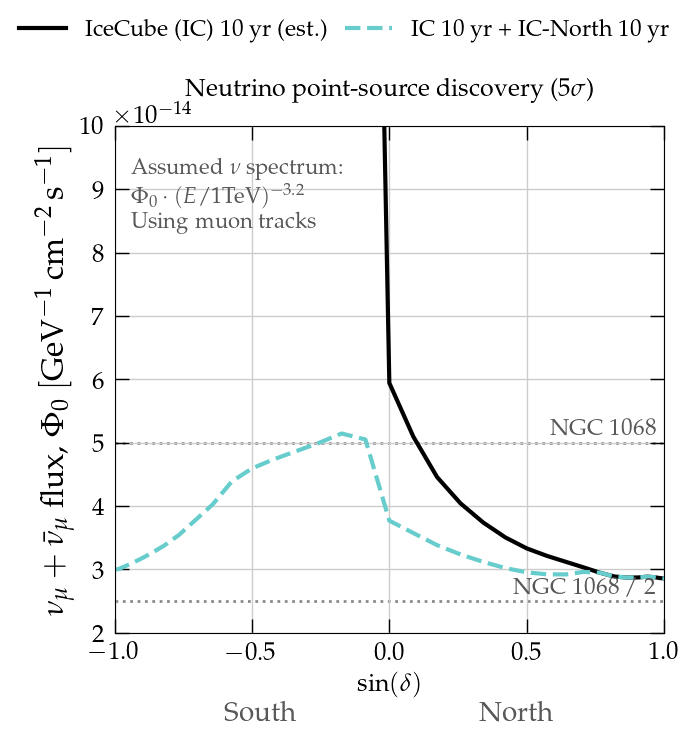

In [11]:
f, ax = plt.subplots(figsize=(7, 8))
for ident, series in flux_ps.groupby("ident"):
    if ident == "IceCube" or ident == "P-ONE":
        plt.plot(
            np.sin(series.dec),
            series.disc5,
            lw=3,
            **{k: det_plotting[ident][k] for k in ["ls", "color", "label"]},
        )
    else:
        continue
# ax.set_yscale("log")
ax.set_xlabel(r"$\sin(\delta)$")
# ax.set_ylabel(
#     r"$\Phi^{\mathrm{disc.~5\sigma}}_{1\rm TeV} ~ / \rm GeV^{-1} \, cm^{-2} \, s^{-1}$"
# )
ax.set_ylabel(
    r"$\nu_\mu + \bar{\nu}_\mu$ flux, $\Phi_{0} ~ [\rm GeV^{-1} \, cm^{-2} \, s^{-1}]$",
    fontsize=23,
)
f.legend(
    loc="upper center",
    frameon=False,
    fontsize="large",
    ncol=2,
    bbox_to_anchor=(0.5, 0.93),
    columnspacing=0.8,
)
ax.set_ylim(2e-14, 1e-13)
ax.set_xlim(-1, 1)
font_color = "0.35"
for ii in [1, 2]:
    ax.axhline(ngc_flux.norm / ii, ls=":", lw=2, color=font_color, zorder=0, alpha=0.7)
    ax.text(
        x=0.97,
        y=ngc_flux.norm / ii,
        va="bottom",
        s="NGC 1068" if ii == 1 else f"NGC 1068 / {ii}",
        color=font_color,
        fontsize="large",
        ha="right",
    )
ax.text(
    0.2, -0.175, "South", fontsize="x-large", color=font_color, transform=ax.transAxes
)
ax.text(
    0.8,
    -0.175,
    "North",
    ha="right",
    fontsize="x-large",
    color=font_color,
    transform=ax.transAxes,
)

f.subplots_adjust(top=0.77)
# ax.set_title(r"Powerlaw flux, $\gamma=-3.2$")
ax.set_title(r"Neutrino point-source discovery ($5\sigma$)")
ax.annotate(
    r"Assumed $\nu$ spectrum: "
    + "\n"
    + r"$\Phi_0 \cdot (E/{\rm 1 TeV})^{-3.2}$"
    + "\n Using muon tracks",
    #     xy=(2037.5, 0.045),
    xy=(-0.94, 0.95e-13),
    ha="left",
    va="top",
    zorder=10,
    color=font_color,
    fontsize=16,  # "large",
)

f.savefig(join(st.BASEPATH, plot_path, "ngc_disc_pot.pdf"), bbox_inches="tight")

# Time evolution

## point source discovery

In [3]:
flux_psd = pd.read_csv(
    "../../resources/point-source_discovery_time-evolution.csv"
)


In [4]:

icecube_ref_time = st.LIVETIME_DAYS / 365 # in years; approx. 9.7 Years of full detector (NGC 1068 analysis)

start_dates = [
    {"label": r"IceCube", "detector": "IceCube", "Year": 2020-icecube_ref_time, "colors": "0.8", "end": 2040},
    {"label": r"+ 7.5$\times$ IceCube (South)", "detector": "Gen-2", "Year": 2040, "colors": "0.5", "end": 2060},
    {"label": r"+ 1$\times$ IceCube (North)", "detector": "KM3NeT", "Year": 2025, "colors": st.colors[2], "end": 2060},
    {"label": r"+ 1$\times$ IceCube (North)", "detector": "Baikal-GVD", "Year": 2030, "colors": st.colors[1], "end": 2060},
    {"label": r"+ 1$\times$ IceCube (North)", "detector": "P-ONE", "Year": 2035, "colors": st.colors[0], "end": 2060},
]
start_dates = pd.DataFrame(start_dates)
start_dates = start_dates.set_index("detector")
yr_max = 2055
Years = np.arange(2020, yr_max)



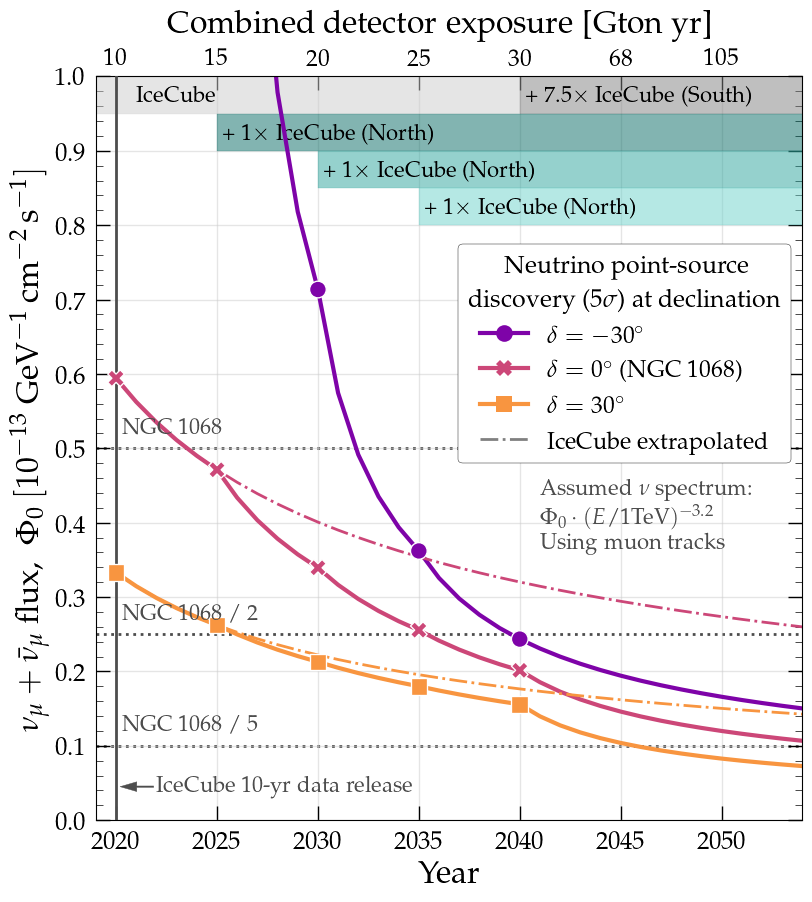

In [5]:
f, ax = plt.subplots(figsize=(9, 9))
# f, ax = plt.subplots(figsize=(6, 5))

edge = 1
ax.set_ylim(0, edge)
width = 0.5e-1  # 0.6e-1
font_color = "0.3"
sigma_ref = 5
ax.axvline(2020, zorder=10, color=font_color)
ax.annotate(
    "IceCube 10-yr data release",
    (2020.2, 0.045),
    (2022, 0.045),
    ha="left",
    va="center",
    zorder=10,
    arrowprops=dict(width=1, headwidth=7, color=font_color),
    color=font_color,
    fontsize=16,  # "large",
)
ax.annotate(
    r"Assumed $\nu$ spectrum: "
    + "\n"
    + r"$\Phi_0 \cdot (E/{\rm 1 TeV})^{-3.2}$"
    + "\n Using muon tracks",
    xy=(2041, 0.46),
    ha="left",
    va="top",
    zorder=10,
    color=font_color,
    fontsize=16,  # "large",
)


for yr_i, series in start_dates.iterrows():
    if not "Gen" in yr_i:
        edge -= width
    length = 50 if not yr_i == "IceCube" else series.end - series.Year
    ax.add_patch(
        Rectangle(
            (series.Year, edge), length, width, color=series.colors, zorder=1, alpha=0.5
        )
    )
    ax.text(
        x=series.Year + 0.3 if yr_i != "IceCube" else 2021,
        y=edge + 0.45 * width,
        s=series.label,
        ha="left",
        va="center",
        fontsize=16,  # "x-large",
        zorder=2,
    )
# plenum evolution
ax = sns.lineplot(
    data=flux_psd.loc[
        (flux_psd.sigma == sigma_ref) & (flux_psd.identifier == "PLEnuM")
    ],
    x="Year",
    y="scaled_flux",
    hue="dec_label",
    hue_order=["-30°", "0°", "30°"],
    style_order=["-30°", "0°", "30°"],
    style="dec_label",
    units="dec",
    lw=3,
    legend=False,
    palette="plasma",
    dashes=False,
)
# icecube-only extrapolated
ax = sns.lineplot(
    data=flux_psd.loc[
        (flux_psd.sigma == sigma_ref) & (flux_psd.identifier == "IceCube extrapolated")
    ],
    x="Year",
    y="scaled_flux",
    hue="dec_label",
    hue_order=["-30°", "0°", "30°"],
    units="dec",
    lw=2,
    ls="-.",
    legend=False,
    palette="plasma",
)


# plenum evolution markers
selection = flux_psd.loc[
    (flux_psd.sigma == sigma_ref) & (flux_psd.identifier == "PLEnuM")
]
selection = selection.loc[(selection.Year < 2041) & (selection.Year % 5 == 0)]
ax = sns.scatterplot(
    data=selection,
    x="Year",
    y="scaled_flux",
    hue="dec_label",
    hue_order=["-30°", "0°", "30°"],
    style="dec_label",
    markers=["X", "s", "o"],
    s=12**2,
    palette="plasma",
    ax=ax,
    legend=False,
    zorder=11,
)
# extra plotting for legend
selection = flux_psd.loc[
    (flux_psd.sigma == sigma_ref) & (flux_psd.identifier == "PLEnuM")
]
selection = selection.loc[selection.Year == 2035]
ax = sns.lineplot(
    data=selection,
    x="Year",
    y="scaled_flux",
    hue="dec_label",
    hue_order=[
        r"$\delta = -30^\circ$",
        r"$\delta = 0^\circ$~(NGC 1068)",
        r"$\delta = 30^\circ$",
    ],
    style_order=[
        r"$\delta = -30^\circ$",
        r"$\delta = 0^\circ$~(NGC 1068)",
        r"$\delta = 30^\circ$",
    ],
    style="dec_label",
    units="dec",
    lw=3,
    ms=12,
    palette="plasma",
    markers=["o", "X", "s"],
    dashes=False,
)
# IceCube extrapolated for legend
plt.plot([-1, -3], [-1, -3], ls="-.", color="gray", label="IceCube extrapolated")

legend = ax.legend(
    bbox_to_anchor=(1.0, 0.79),
    #     bbox_to_anchor=(1.0, 0.75),
    framealpha=1,
    loc=1,
    #     title="Source declination, $\delta$:",
    title=r"\hspace*{0.6em}Neutrino point-source\\[0.3em] discovery ($5\sigma$) at declination",
    ncol=1,
    fontsize=17,
    edgecolor="k",
)
plt.setp(legend.get_title(), fontsize=18)  # "x-large")
for line in legend.get_lines()[:-1]:
    line.set_linewidth(3)
    line.set_markersize(12)

# Top x-axis (artificial, for simplicity)
volume_ic = 1.0  # IceCube volume [Gton]
ic_start = 2010  # 2011


def exposure_combined(year):
    if year <= 2025:
        exposure = volume_ic * (year - ic_start)
    elif 2025 < year <= 2030:
        exposure = exposure_combined(2025) + (year - 2025) * volume_ic
    elif 2030 < year <= 2035:
        exposure = exposure_combined(2030) + (year - 2030) * volume_ic
    elif 2035 < year <= 2040:
        exposure = exposure_combined(2035) + (year - 2035) * volume_ic
    elif year > 2040:
        exposure = exposure_combined(2040) + (year - 2040) * 7.5 * volume_ic
    return exposure


for year in np.linspace(2020, 2050, 7):
    ax.text(
        x=year,
        y=1.015,
        s="{:0.0f}".format(exposure_combined(year)),
        fontsize=17,
        ha="center",
    )
ax.text(
    x=2036, y=1.06, s="Combined detector exposure [Gton~yr]", fontsize=23, ha="center"
)

ax.set_xlim(2019, yr_max - 1)
ax.set_xlabel(r"Year", fontsize=23)
ax.set_ylabel(
    r"$\nu_\mu + \bar{\nu}_\mu$ flux,~~$\Phi_{0} ~ [10^{-13}~\rm GeV^{-1} \, cm^{-2} \, s^{-1}]$",
    fontsize=23,
)

for ii in [1, 2, 5]:
    ax.axhline(st.PHI_NGC * 1e13 / ii, ls=":", lw=2, color=font_color, zorder=0)
    ax.text(
        x=2020 + 0.3,
        y=0.02 + st.PHI_NGC * 1e13 / ii,
        s="NGC 1068" if ii == 1 else f"NGC 1068 / {ii}",
        color=font_color,
        fontsize=16,  # "large",
        zorder=20,
    )

ax.grid(alpha=0.5)
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.02))

# ax.set_title("Point-source discovery potential ($5 \sigma$)", fontsize="xx-large", pad=60)
f.savefig(
    join(st.BASEPATH, plot_path, "time_evolution_significance_ps.pdf"),
    dpi=300,
    bbox_inches="tight",
)